# 💼 Job Application Assistant with LangChain, Vector Search, and Streamlit

**Author**: Anna Kadurina

**Date**: May 2025  

This notebook documents the design, architecture, and implementation of an NLP assistant that helps users optimize their job applications. It uses LangChain to integrate multiple LLMs, vector search for semantic matching, and Streamlit for the user interface.

## 🧩 Design Challenge

Design a job application assistant to enable job seekers in the hiring process to optimize their CV and generate tailored motivation letters with high accuracy and personalization.

## 🎯 Project Overview & Objective
**Goal**: Build an intelligent agent that:
- Takes a CV and a job description
- Uses semantic vector search to identify alignment
- Suggests CV improvements based on job description
- Generates a tailored motivation letter using LLMs

**Core Technologies**:
- LangChain
- Vector Store (FAISS)
- Multiple LLMs (e.g., Mistral via Ollama, GPT-4 via OpenAI)
- Streamlit
- Python

## 🏗️ System Architecture Overview

```text
User Input (CV + Job Description via Streamlit or Notebook UI)
          ↓
Generate Embeddings using a Model (e.g., OpenAI or HuggingFace)
          ↓
Store and Index Embeddings in a Vector Database (FAISS)
          ↓
Perform Similarity Search to Identify Key Matches
          ↓
Use LangChain with LLMs:
  → Prompt for CV Improvement Suggestions
  → Prompt for Motivation Letter Generation
          ↓
Display AI-Generated Output to the User

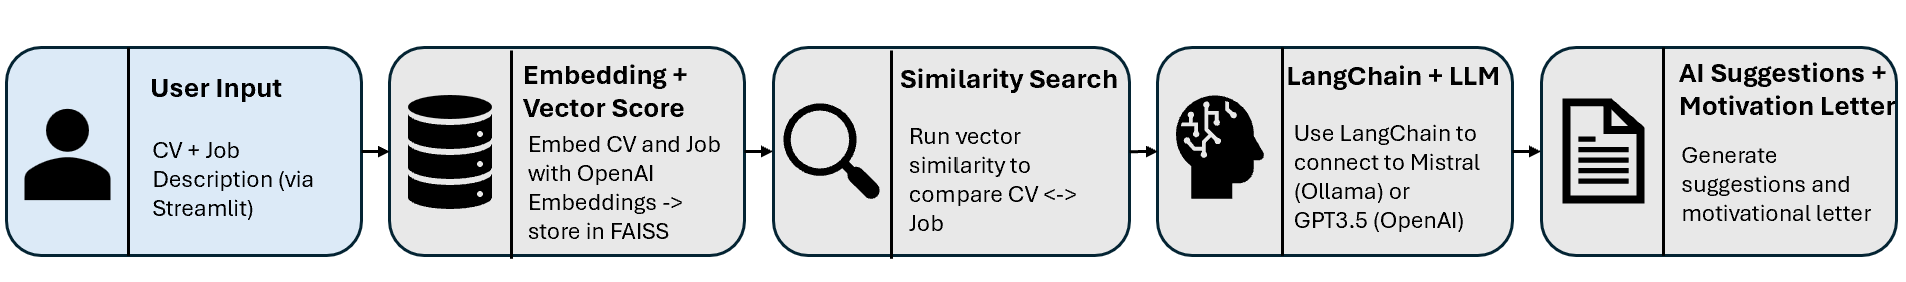

In [ ]:
display(Image(filename='architecture.png'))

## 📦 Import Libraries

In [41]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_community.llms import Ollama
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
import ipywidgets as widgets
from IPython.display import display, Markdown, Image
import fitz 
from sklearn.metrics.pairwise import cosine_similarity
from langchain.llms import OpenAI

## 🧾 Inputs

To begin, the user provides three types of input:

1. A **CV** – either by uploading a PDF file or pasting the content directly into a text box.
2. A **job description** – describing the role the user is applying for.
3. A **model selection** – allowing the user to choose between a local model (e.g., Mistral via Ollama) or a cloud-based model (e.g., GPT-3.5 via OpenAI).

These inputs are essential for the system to analyze the alignment between the candidate’s experience and the job requirements.  
The selected model will later generate improvement suggestions and a personalized motivation letter based on these inputs.

In [42]:
cv_input = widgets.Textarea(
    value='',
    placeholder='Paste your CV here if you don’t upload a PDF',
    description='CV:',
    layout=widgets.Layout(width='100%', height='120px')
)

job_input = widgets.Textarea(
    value='Looking for a data analyst...',
    placeholder='Paste job description here',
    description='Job:',
    layout=widgets.Layout(width='100%', height='120px')
)

model_selector = widgets.Dropdown(
    options=['mistral (local)', 'gpt-3.5-turbo (OpenAI)'],
    description='Model:',
    style={'description_width': 'initial'}
)

pdf_uploader = widgets.FileUpload(
    accept='.pdf',
    multiple=False,
    description='Upload CV PDF'
)

display(pdf_uploader, cv_input, job_input, model_selector)


FileUpload(value=(), accept='.pdf', description='Upload CV PDF')

Textarea(value='', description='CV:', layout=Layout(height='120px', width='100%'), placeholder='Paste your CV …

Textarea(value='Looking for a data analyst...', description='Job:', layout=Layout(height='120px', width='100%'…

Dropdown(description='Model:', options=('mistral (local)', 'gpt-3.5-turbo (OpenAI)'), style=DescriptionStyle(d…

## 📤 PDF Extraction

To make the assistant more practical, users are given the option to upload their CV as a PDF file.  
This section handles the extraction of plain text from the uploaded PDF using the PyMuPDF (`fitz`) library.

If a PDF is uploaded, the code reads and extracts its text page by page. If no PDF is provided, it falls back to using the text input from the CV textarea.  
This ensures flexibility for users while guaranteeing that the assistant always has a CV to work with in the next steps (embeddings, similarity analysis, and LLM generation).

In [ ]:
def extract_pdf_text(upload_widget):
    if not upload_widget.value:
        return ""
    uploaded_file = list(upload_widget.value)[0]
    content = uploaded_file['content'] if isinstance(uploaded_file, dict) else uploaded_file[1]['content']
    
    with open("uploaded_cv.pdf", "wb") as f:
        f.write(content)

    doc = fitz.open("uploaded_cv.pdf")
    full_text = "".join([page.get_text() for page in doc])
    doc.close()
    return full_text.strip()

extracted_cv = extract_pdf_text(pdf_uploader)
cv_text = extracted_cv if extracted_cv else cv_input.value
job_desc = job_input.value


## 🔍 Semantic Embedding & Similarity Analysis

This section converts both the CV and job description into **semantic vector representations** using the OpenAI Embedding API.  
These embeddings allow us to measure how similar the two texts are, not just by keywords but by meaning.

We first store the documents in a **FAISS vector database**, which enables fast and efficient similarity searches.  
Then, a sample query (e.g., "data analysis and dashboards") is used to find the most relevant section from either document.

Additionally, we compute a **cosine similarity score** between the CV and job description embeddings.  
This numeric score (0–100%) quantifies how well the CV aligns with the job role at a semantic level.

In [ ]:
documents = [Document(page_content=cv_text), Document(page_content=job_desc)]
embedding_model = OpenAIEmbeddings(openai_api_key="secret")
vector_store = FAISS.from_documents(documents, embedding_model)

query = "data analysis and dashboards"
similar_docs = vector_store.similarity_search(query)

display(Markdown("### 🔍 Most Relevant Match:"))
display(Markdown(similar_docs[0].page_content))

cv_embedding = embedding_model.embed_query(cv_text)
job_embedding = embedding_model.embed_query(job_desc)
similarity = cosine_similarity([cv_embedding], [job_embedding])[0][0]
print(f"🔗 Similarity Score: {round(similarity * 100, 2)}%")


### 🔍 Most Relevant Match:

PROFILE
I am a dedicated
professional who actively
seeks opportunities for
personal and career
growth. Along with my
work, I have offered my
time for a number of
charitable causes. Outside
of my work, I am a friendly
and energetic individual
who is passionate about
sports.
CONTACT ME
+359893694238
anikadurinaa@gmail.com
Smitsstraat 11,
5611HM,
Eindhoven, The
Netherlands
WORK EXPERIENCE
VAN LANSCHOT KEMPEN - BACKEND
DEVELOPER INTERN
01/02/2024 - 30/06/2024
EDUCATION
FONTYS UNIVERSITY OF APPLIED SCIENCES,
EINDHOVEN, THE NETHERLANDS
ICT and Software Engineering with AI
01/09/2021 - ongoing
LANGUAGE HIGH SCHOOL “AKAD. L.
STOYANOV”, BLAGOEVGRAD, BULGARIA
German language, English language,
Bulgarian language, IT
15/09/2016 - 15/05/2021
LANGUAGE
Bulgarian - native
English - advanced (C1/C2)
German - intermediate (B1/B2)
ANNA
KADURINA
Software Engineering and AI Student
VAN LANSCHOT KEMPEN - BACKEND
DEVELOPER
10/02/2023 - ongoing
GIT REPOSITORY
WITH MY PREVIOUS
WORK
https://github.com/AnnaK
adurina/Internship-
Application
TECHNICAL SKILLS
C# | .Net Core | Razor Pages | Python | Jupyter
HTML | CSS | JavaScript | React | Angular
Java | SpringBoot | Gradle | Maven
Docker | GIT | SonarQube | MySQL | MSSQL
RECENT PROJECTS
Microservices-based AirBnb alike platform
C# .Net | Azure | Azure DevOps | React | SonarQube |
Snyk | OWASP ZAP | GIT | Azure SQL | Sentry.io
AI models for sentiment analysis and image
recognition
Jupyter | Python | React

🔗 Similarity Score: 80.81%


## ✨ Prompt Engineering & LLM Response

In this section, we use **LangChain** to generate customized output using a large language model (LLM).  
We define a prompt template that clearly instructs the model to:

1. Suggest 3 specific improvements to the candidate's CV based on the job description.
2. Generate a short and professional motivation letter tailored to the job.

Depending on the user's selection, the assistant runs this prompt using either:
- A **local model** like Mistral via **Ollama**
- A **cloud model** like GPT-3.5 via **OpenAI's API**.

The result is a personalized output that helps the user refine their CV and submit a high-quality application.


In [ ]:
prompt = PromptTemplate(
    input_variables=["job_desc", "cv_text"],
    template="""
You are a career assistant.

Here is the job description:
{job_desc}

Here is the candidate's CV:
{cv_text}

1. Suggest 3 ways the candidate can improve the CV to better match the job.
2. Write a short and professional motivation letter tailored to the job.
"""
)

if 'mistral' in model_selector.value.lower():
    from langchain_community.llms import Ollama
    llm = Ollama(model="mistral")
else:
    from langchain.llms import OpenAI
    llm = OpenAI(openai_api_key="secret")

chain = LLMChain(llm=llm, prompt=prompt)
response = chain.run({"job_desc": job_desc, "cv_text": cv_text})

display(Markdown("### ✨ AI Suggestions & Motivation Letter:"))
display(Markdown(response))


### ✨ AI Suggestions & Motivation Letter:

1. Here are three suggestions to help the candidate improve their CV to better match the job as a software developer:

    a) Highlight relevant project experience: The candidate's CV includes two recent projects, but it may be beneficial for them to elaborate on how these projects demonstrate their skills in developing software applications, particularly using popular technologies like C#, .NET Core, React, and Angular. They could also discuss any challenges they faced during the development process and explain how they overcame them.

    b) Emphasize technical skills: While the candidate's CV lists a variety of technical skills, it may be helpful to arrange these skills in a more organized manner, perhaps grouping them by programming languages or software development frameworks. Additionally, including any certifications related to specific technologies could make their profile more attractive to potential employers.

    c) Quantify achievements: Whenever possible, the candidate should provide specific numbers and metrics to demonstrate the impact of their work on projects. This might include the number of users a developed application serves, the percentage improvement in application performance, or any other relevant measure of success.

  2. Here is a short and professional motivation letter tailored for the job as a software developer:

---

Dear Hiring Manager,

I am writing to express my interest in the Software Developer position that I found advertised on your company's website. With my strong background in software engineering, AI, and a passion for continuous learning, I believe I would be an excellent addition to your team.

In my current role as a Backend Developer at Van Lanschot Kempen, I have had the opportunity to develop and maintain various applications using C# .NET, React, Angular, and other technologies. This experience has equipped me with the skills necessary to deliver high-quality software solutions that are scalable, efficient, and user-friendly.

One of my most recent projects was a microservices-based Airbnb-like platform that I developed using C# .Net and Azure. By utilizing Azure DevOps for continuous integration and delivery, I was able to streamline the development process and ensure that our team could quickly respond to feedback and make improvements. In addition, I leveraged Snyk, OWASP ZAP, and GIT for security testing and version control during the development lifecycle.

As someone who is dedicated to personal and career growth, I am eager to join a dynamic company like yours where I can contribute my skills and continue learning from talented professionals. In my free time, I enjoy participating in charitable causes and staying active by playing sports.

Thank you for considering my application. I look forward to the opportunity to discuss how my background and skills would be an asset to your team. Please find my GIT repository with my previous work at [https://github.com/AnnaKadurina/Internship-Application].

Best regards,
Anna Kadurina
Software Engineering and AI Student
+359893694238
anikadurinaa@gmail.com
Smitsstraat 11, 5611HM Eindhoven, The Netherlands

## 🧪 Model Comparison: Mistral vs OpenAI GPT

To understand the differences in output quality and style between language models, this section runs the same prompt through **two different LLMs**:

- **Mistral**, a local open-source model served via **Ollama**
- **GPT-3.5**, a cloud-based commercial model from **OpenAI**

By comparing the outputs side-by-side, users can evaluate how each model interprets the task, how detailed or relevant their suggestions are, and which tone or style suits their needs best.  
This also demonstrates the flexibility of the LangChain framework to switch between or integrate multiple models in one workflow.

In [ ]:
mistral = Ollama(model="mistral")
gpt = OpenAI(openai_api_key="secret", max_tokens=1000)

chain_mistral = LLMChain(llm=mistral, prompt=prompt)
chain_gpt = LLMChain(llm=gpt, prompt=prompt)

output_mistral = chain_mistral.run({"job_desc": job_desc, "cv_text": cv_text})
output_gpt = chain_gpt.run({"job_desc": job_desc, "cv_text": cv_text})

from IPython.display import Markdown
display(Markdown("### 🤖 Mistral Output:"))
display(Markdown(output_mistral))

display(Markdown("### ☁️ OpenAI GPT Output:"))
display(Markdown(output_gpt))


### 🤖 Mistral Output:

1. Here are three suggestions to improve the CV for a software developer position:

   - Emphasize relevant technical skills: While the candidate has a diverse range of technical skills, it would be beneficial to highlight those that are most relevant to the job as a software developer, such as C#, .Net Core, Razor Pages, and React.

   - Showcase relevant work experience: The CV mentions the candidate's current internship as a backend developer at Van Lanschot Kemper, but it would be helpful to expand on this experience by discussing the specific projects or technologies worked on during the internship.

   - Include any open-source contributions or personal projects: A strong portfolio of relevant projects demonstrates the candidate's problem-solving skills and ability to work independently. The GitHub link provided is a good start, but it would be helpful to provide brief descriptions of each project and highlight specific accomplishments or challenges overcome.

  2. Here's a short and professional motivation letter tailored to the job:

---

Dear Hiring Manager,

I am writing to express my strong interest in the software developer position at your company. As an ICT and Software Engineering with AI student at Fontys University of Applied Sciences, I have gained extensive technical knowledge and practical experience through classroom instruction, internships, and independent projects.

In my current role as a backend developer intern at Van Lanschot Kemper, I have honed my skills in C#, .Net Core, and Razor Pages, while collaborating closely with other developers to create high-quality software solutions. During this internship, I was given the opportunity to work on a microservices-based Airbnb-like platform using Azure, React, SonarQube, Snyk, OWASP ZAP, and GIT, which has provided me with valuable real-world experience in developing large-scale applications.

Outside of my studies and internship, I have actively contributed to open-source projects on GitHub, including the development of AI models for sentiment analysis and image recognition using Python, Jupyter, and React. These projects have allowed me to apply my technical skills in a creative and challenging context, while also demonstrating my ability to work independently and collaboratively.

I am passionate about software development and eager to continue growing both personally and professionally within your team. I believe that my strong technical skills, combined with my enthusiasm for problem-solving and adaptability, make me an ideal candidate for this position.

Thank you for considering my application. I look forward to the opportunity to discuss how I can contribute to your company's success.

Sincerely,
Anna Kadurina

---

### ☁️ OpenAI GPT Output:


1. Three ways the candidate can improve their CV to better match the job are:

- Highlighting their relevant technical skills and experience: As a software developer, it is important for the candidate to showcase their proficiency in programming languages, tools, and technologies. They can do this by including a separate section for technical skills and providing specific examples of projects they have worked on.

- Adding more details about their education: While the candidate has mentioned their current education in software engineering and AI, they can provide more information about their coursework, projects, and any relevant achievements. This will give the employer a better understanding of their academic background and how it aligns with the job requirements.

- Including a section for relevant certifications or courses: The candidate can also mention any certifications or courses they have completed that are relevant to the job. This could include online courses, workshops, or training programs that showcase their commitment to continuous learning and development.

2. Motivation letter:

[Your Name]
[Address]
[City, State ZIP Code]
[Email Address]
[Today’s Date]

[Employer's Name]
[Company Name]
[Address]
[City, State ZIP Code]

Dear [Employer’s Name],

I am writing to express my interest in the software developer position at [Company Name]. As a dedicated and passionate software engineering and AI student, I am excited about the opportunity to contribute my skills and knowledge to your organization.

I am currently pursuing my degree in ICT and Software Engineering with AI at Fontys University of Applied Sciences. Through my coursework, I have gained a strong foundation in programming languages such as C#, Python, and Java, as well as experience with various tools and technologies including HTML, CSS, JavaScript, React, and Angular. In addition, my internship as a backend developer at Van Lanschot Kempen has provided me with hands-on experience in using .Net Core, Razor Pages, and Docker.

Moreover, I have a keen interest in the latest advancements in the field of AI and have completed projects in sentiment analysis and image recognition using Jupyter and Python. I am also familiar with agile methodologies and have worked on a microservices-based AirBnb alike platform using Azure, Git, and React.

Apart from my technical skills, I am a friendly and energetic individual who thrives in a collaborative and fast-paced environment. I am always eager to learn and take on new challenges, and I believe my strong work ethic and attention to detail make me a valuable asset to any team.

I am confident that my skills and experience make me a strong candidate for the software developer position at [Company Name]. I would welcome the opportunity to discuss how I can contribute to your team and learn more about your organization. Thank you for considering my application.

Sincerely,
[Your Name]

## 🌐 Streamlit Interface

To complement the notebook-based development and allow for an interactive user experience, a Streamlit web application was created. The app provides a friendly interface where users can:
- Upload or paste their CV
- Enter a job description
- Choose between local or cloud-based LLMs (e.g., Mistral via Ollama or GPT-3.5 via OpenAI)
- View similarity scores between their CV and the job posting
- Receive AI-generated CV improvement suggestions and a tailored motivation letter

The decision to use Streamlit was motivated by its ability to rapidly prototype and deploy interactive NLP tools with minimal overhead. In particular, hosting the app locally allowed me to integrate Mistral via Ollama, which runs fully on the user’s machine without any external API calls. This enables privacy, cost-efficiency, and offline functionality.

The Streamlit app demo is included in the submission as part of the deliverables. It serves as a realistic frontend for real-world users to engage with the underlying LangChain pipeline.

## ✅ Conclusion

This project demonstrates how modern NLP tools can be combined to build intelligent, task-specific agents. Using LangChain, I orchestrated multiple components—embedding models, vector similarity search, and large language models—into a coherent pipeline capable of analyzing CVs, assessing their alignment with job descriptions, and producing actionable outputs.

I showed how users can benefit from:
- CV parsing and semantic analysis
- Adaptive reasoning via local and cloud LLMs
- An interactive interface for input and feedback
- Similarity scoring for alignment evaluation

The project not only deepened my understanding of the NLP pipeline, embeddings, and chaining techniques but also showcased how combining open-source tools like Ollama, FAISS, and Streamlit can lead to practical AI assistants with real-world potential.